In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
import sys
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

### Loading

In [2]:
reviews = pd.read_csv('data/cleaned/reviews.csv.gz', compression='gzip')
ratings = pd.read_csv('data/cleaned/ratings.csv.gz', compression='gzip')
users = pd.read_csv('data/cleaned/users.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/cleaned/beers.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/cleaned/breweries.csv.gz', compression='gzip')

## Seasonal trend analysis

To understand the seasonal analysis, it is important to understand how the beers are rated. In both reviews and ratings dataframes, 6 columns contain metrics ( which are a score out of 5): appearance, aroma, taste, mouthfeel, overall and rating. The rating metrics is computed based on the 5 other scores with the following formula:
$$
\text{rating} = 0.06 \cdot \text{appearance} + 0.24 \cdot \text{aroma} + 0.4 \cdot \text{taste} + 0.1 \cdot \text{mouthfeel} + 0.2 \cdot \text{overall}
$$


In [45]:
from src.scripts.statistics import anova_test

In [ ]:
print("Number of NaN values in ratings:", ratings['rating'].isnull().sum())

Number of NaN values in ratings:  444092


In [47]:
ratings = ratings.dropna(subset=['rating'])

In [48]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
ratings['season'] = pd.Categorical(ratings['season'], categories=season_order, ordered=True)

### For all years

In this section, we analyze the impact of style and alcohol concentration on the rating of a beer across seasons. This analysis is performed with the ratings from all years selected in the previous section.

#### By simplified styles

In this subsection, we analyze the impact of the style of the beer on its rating across seasons.

In [3]:
style_count = beers_ba['style_simp'].value_counts()

# Determine the threshold for 'Other' category 
threshold = 5000 

# Filter styles with a count greater than or equal to 2% of the total count
beer_styles_above_2_percent = style_count[style_count >= threshold].index.tolist()

In [51]:
ratings_top_styles = ratings[ratings['style_simp'].isin(beer_styles_above_2_percent)]
reviews_top_styles = reviews[reviews['style_simp'].isin(beer_styles_above_2_percent)]

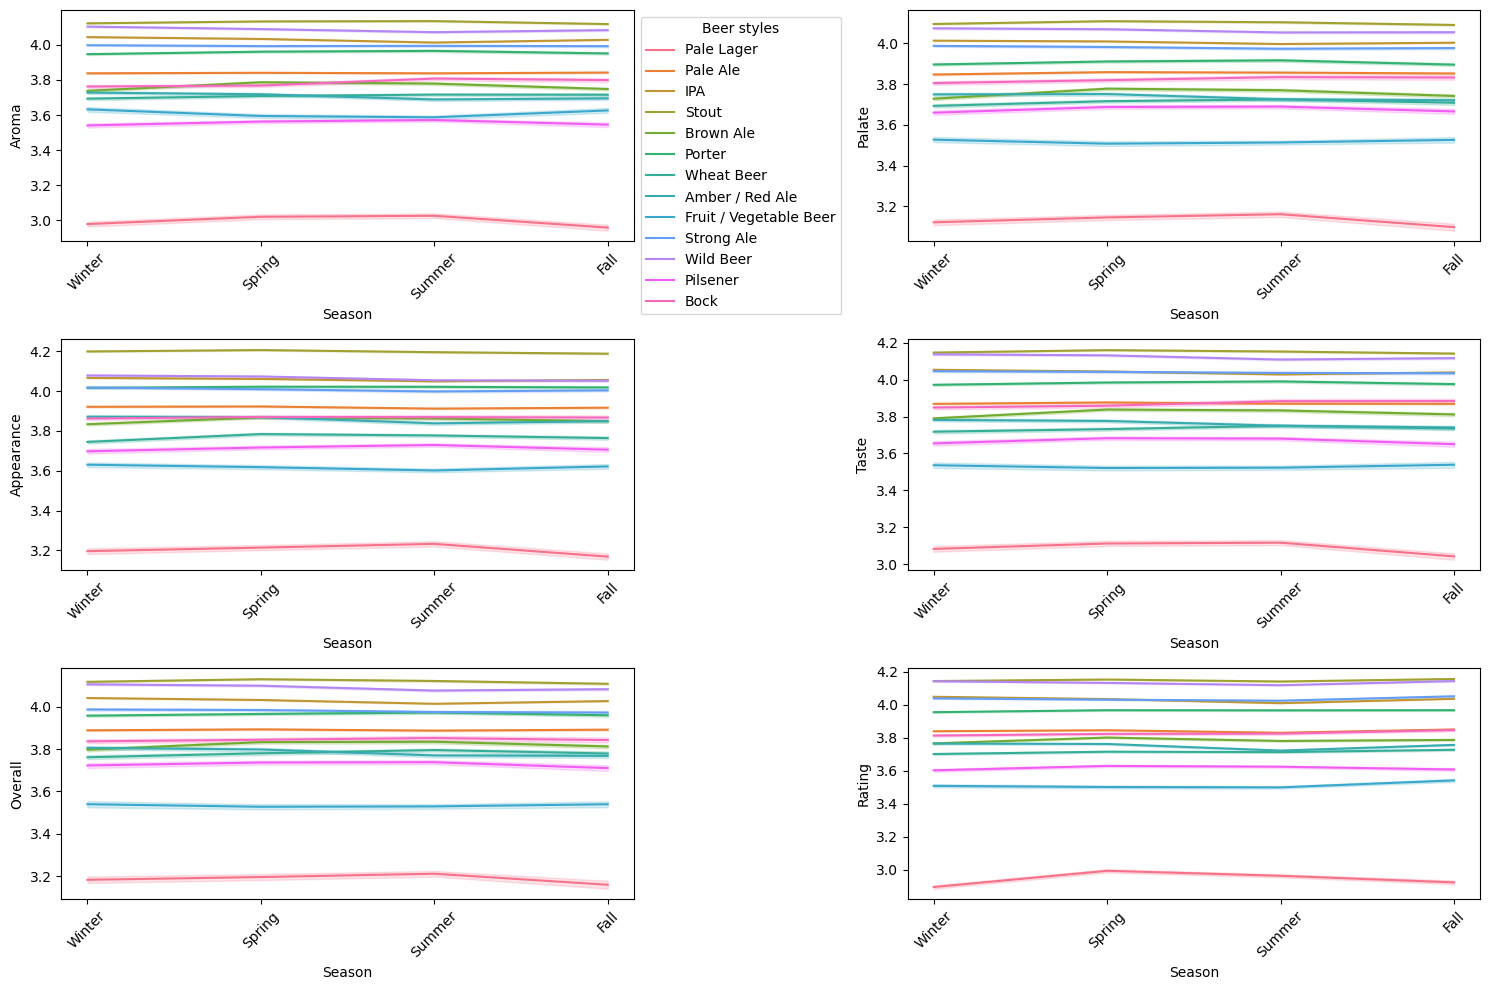

In [52]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings_top_styles, x='season', y=rating, hue='style_simp', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Beer styles', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

From the plots above, we can observe that the beers belonging to the **Pale Lager** style show visible variation beetween seasons, especially between winter and spring. For the other styles, the variability is not visible if it exists, especially in the rating score, which contains all other metrics.

In [53]:
anova_season_rating_style = anova_test(ratings_top_styles, rating_column='rating', timescale='season', category='style_simp') 

style_simp: Pale Lager, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0701    0.0  0.0502    0.09   True
  Fall Summer   0.0399    0.0  0.0207  0.0591   True
  Fall Winter   -0.028 0.0019  -0.048  -0.008   True
Spring Summer  -0.0302 0.0001 -0.0487 -0.0118   True
Spring Winter  -0.0981    0.0 -0.1174 -0.0788   True
Summer Winter  -0.0679    0.0 -0.0864 -0.0493   True
----------------------------------------------------
--------------------------------------------------
style_simp: Pale Ale, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring  -0.0048 0.0489 -0.0095    -0.0 

The variability visibly seen in the graph for the **Pale Lager** style, is also seen in the ANOVA statistical test. Particularly, there is almost a 0.1 difference in between the ratings in spring and winter; the beer style is rated lower in winter than in spring. 

The **Bitter** style shows no difference in ratings amongst pairs with the Tukey HSD, the group anova p_value was 0.04 so the difference in between the groups was not significant.

For other all other beer styles, at least one difference in between season is observed. A few beer styles are consistently rated higher in fall than in winter: **Pale Ale** (~0.02 difference), **IPA** (~0.03) and **Stout** (~0.02).

We can also observe some paterns in terms of rating for some beer styles:
* **Brown Ale**: In spring, the beer is rated higher than in winter (~0.04); fall and summer ratings are similar 
* **Porter**: Winter ratings are lower than the ones in all other seasons (~0.01)
* **Amber/Red Ale**: Summer ratings are higher than in all other seasons (~0.04)
* **Pilsener**: Fall and winter have similar ratings, same phenomenon for spring and summer; spring and summer ratings are higher than in fall and winter

#### By alcohol concentration

In this subsection, we analyze the impact of the concentration of alcohol on a beer rating across seasons. 

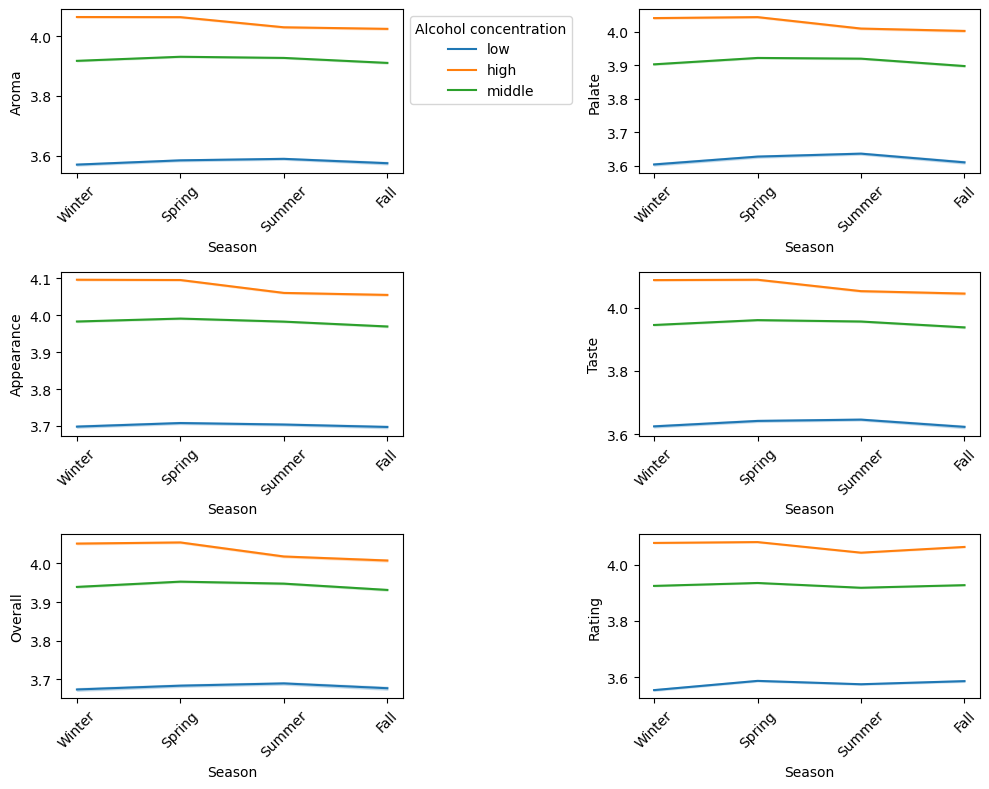

In [54]:
plt.figure(figsize=(10, 8))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings, x='season', y=rating, hue='abv_category', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

All metrics follow the same trend across seasons for each alcohol concentration category. Very few variation is observed in between seasons visually. Winter ratings seem to be lower than for other seasons for beers with low alcohol concentration. The opposite can be observed for beers with higher alcohol concentration, they are rated higher in winter than in summer.

In [55]:
anova_season_rating_abv = anova_test(ratings, rating_column='rating', timescale='season', category='abv_category') 

abv_category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  Fall Spring   0.0009 0.959 -0.0037  0.0054  False
  Fall Summer  -0.0111   0.0 -0.0154 -0.0067   True
  Fall Winter   -0.032   0.0 -0.0366 -0.0273   True
Spring Summer   -0.012   0.0 -0.0163 -0.0077   True
Spring Winter  -0.0328   0.0 -0.0374 -0.0283   True
Summer Winter  -0.0209   0.0 -0.0253 -0.0165   True
---------------------------------------------------
--------------------------------------------------
abv_category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0173    0.0  0.0144  0.0201   True
  Fall Sum

There is a significant difference between ratings for all alcohol concentration in between all seasons; except for the low alcohol concentration beers, in between fall and spring ratings. 

The difference depend on the alcohol concentration category. For example, lower and mid alcohol concentration are rated higher in summer than in winter; it is the opposite way for higher alcohol concentration beers. 

Especially, the higher difference in ratings in between seasons for each alcohol concentration category:
* **low**: The beers are rated higher in spring than in winter (~0.03 difference)
* **mid**: The beers are also rated higher in spring than in winter, but the difference is smaller (~0.01)
* **high**: The beers are rated the lowest during summer compared to fall and winter (~0.04)

### Year by year

##### By simplified style

In this section, we analyze the evolution of ratings for different beer styles across years.

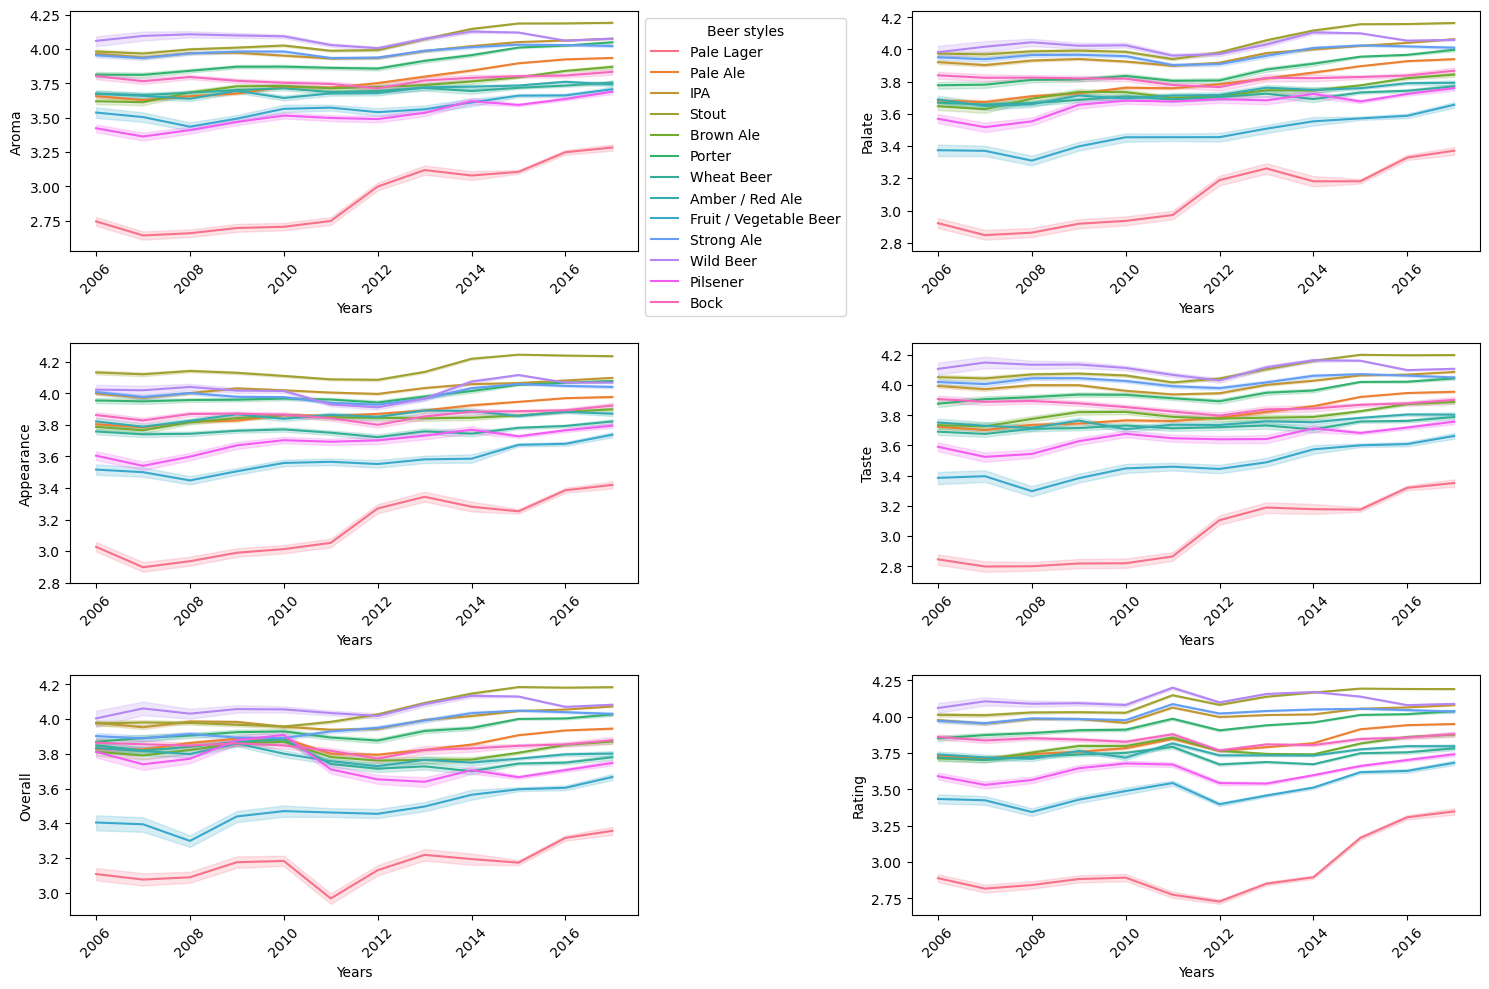

In [56]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings_top_styles, x='year', y=rating, hue='style_simp', markers=True, dashes=False)

    plt.xlabel('Years')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Beer styles', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We can observe from the plots that there has been a clear increase in ratings for the **Pale Lager** beers from around 2012 to 2017. For the other beer styles, there seem to have been a general increase from 2006 to 2017 but it is harder to evaluate. Moreover, it seems that around 2010 to 2012, there has been a decrease in ratings for almost all beer types, followed then by an increase until 2017.

In [ ]:
anova_year_rating_style = anova_test(ratings_top_styles, rating_column='rating', timescale='year', category='style_simp') 

The ANOVA and Tukey HSD taking a lot of space, the important values from those tests are described below. This is not an extensive description but an idea of a validation for the general trend seen on the graph.

From 2006 to 2017, the **Pale Lager** style has indeed increase its rating by 0.46 points; the most significant increase is as seen on the graph between 2012 and 2017, it has increased by 0.62 points. The ratings were stable from 2006 to 2010, it decreased then by 0.16 until 2012 before the increase. 

Other styles such as **Pale Ale** followed the same trend but with less differences; the ratings were stable from 2006 to 2008, an initial increase from 2008 to 2011 of 0.1 points followed by a decrease of 0.08 points in 2012 and then an increase of 0.18 points from 2012 to 2017.

The **Bitter** style shows almost no significant variation in ratings throughout the years. Small fluctuations of about 0.1 points occur, for example the same decrease in between 2011 and 2012 is observed (~0.1) followed by an increase of 0.1 until 2017.

#### By alcohol concentration

In this section, we analyze the impact of the concentration of alcohol on the rating of a beer across years. 

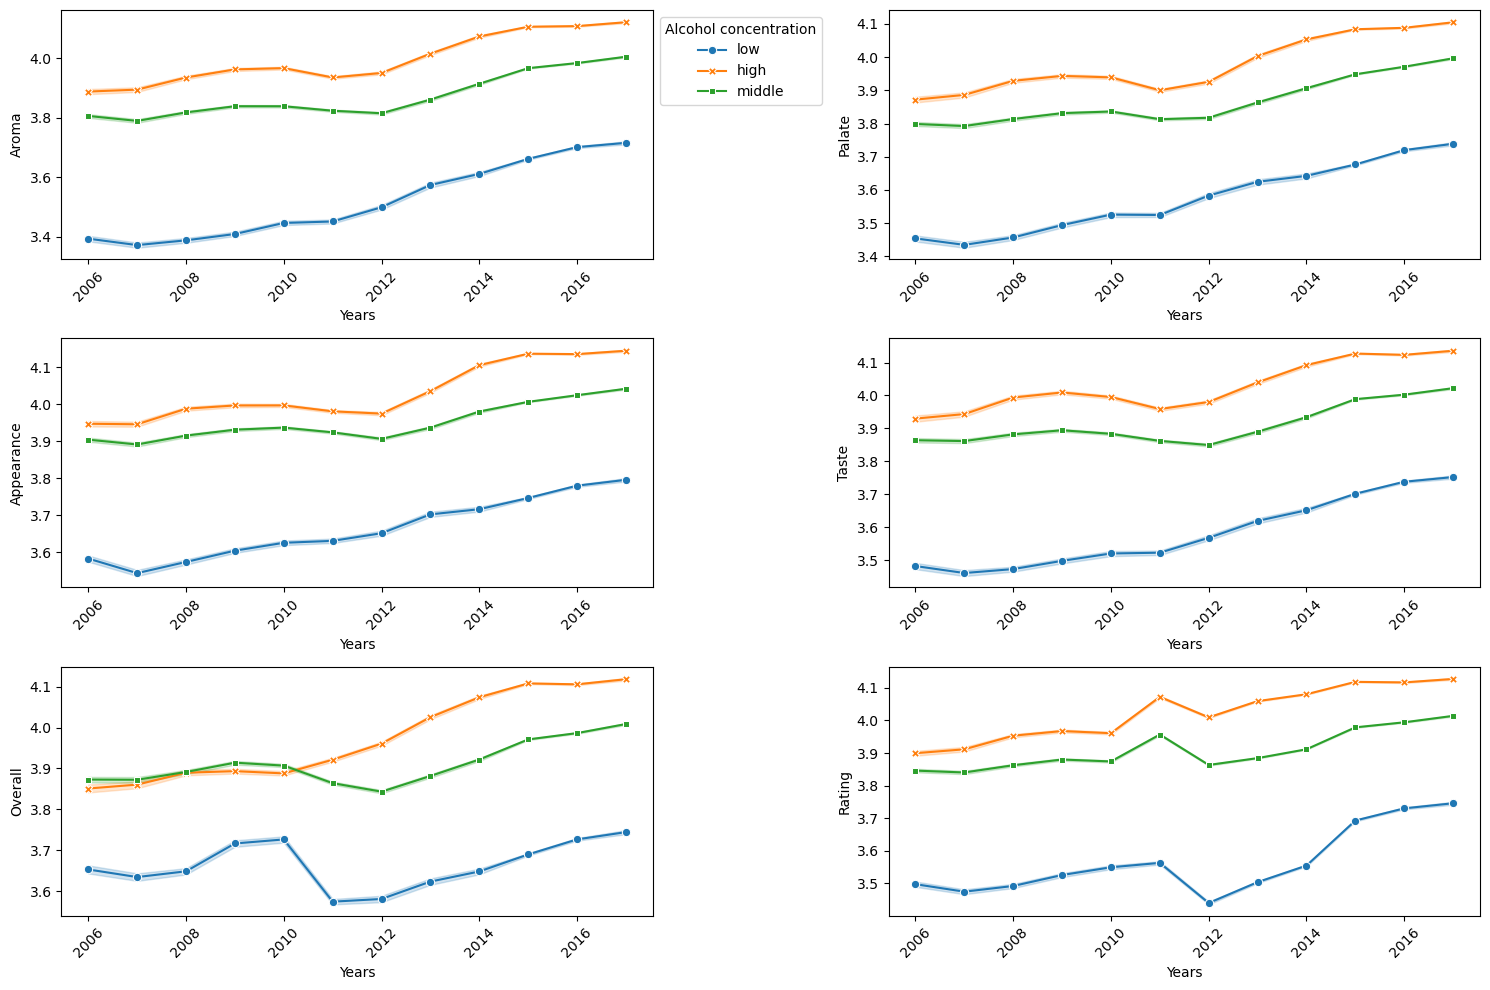

In [58]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings, x='year', y=rating, hue='abv_category', style='abv_category', markers=True, dashes=False)

    plt.xlabel('Years')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

Across years, all metric have the same evolution trend for all alcohol concentrations, except for the overall score which shows more variability. We observe the same general trend as when the beers were separated by style; a slight increase from 2006 to 2011, a decrease between 2011 and 2012, followed by an increase until 2017. 

Besides, we can also observe that the higher the alcohol content, the more a beer is liked. The lower concentration in alcohol consistently obtain lower scores. 

### By states

In this section, we analyze whether the users’ regions of origin influence their ratings across different seasons. The four regions (South, Midwest, Northeast, and West) experience different climate conditions. For example, winters in the Northeast are typically much colder than those in the South. These seasonal climate differences may shape user preferences and, consequently, their ratings. By examining these patterns, we aim to understand if and how seasonal variations across regions impact user ratings.

#### Comparaison by states

First, we need to ensure that the number of ratings is relatively consistent across each category:

/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/907390544.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratings_count = ratings.groupby(['region', 'season'])['overall'].count().reset_index()
/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/907390544.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = ratings_count.pivot_table(


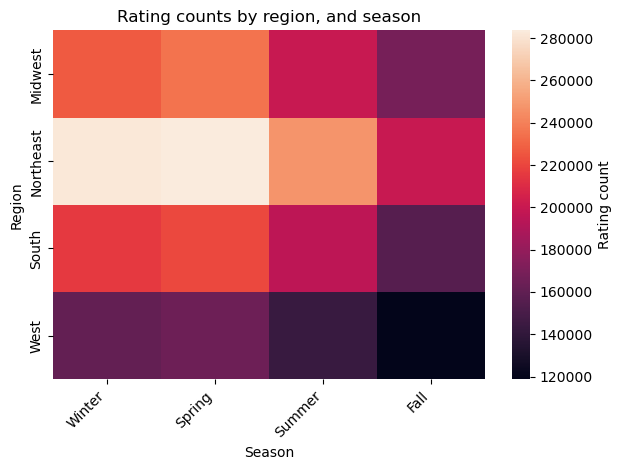

In [59]:
ratings_count = ratings.groupby(['region', 'season'])['overall'].count().reset_index()
ratings_count = ratings_count.rename(columns={'overall': 'rating_count'})

pivot_table = ratings_count.pivot_table(
    index='region', columns='season', values='rating_count', fill_value=0
)

sns.heatmap(pivot_table, cbar_kws={'label': 'Rating count'})
plt.title("Rating counts by region, and season")
plt.xlabel("Season")
plt.ylabel("Region")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There are more ratings from users in the Northeast, which is expected given that states like New York and Pennsylvania are more prominently represented among the users.

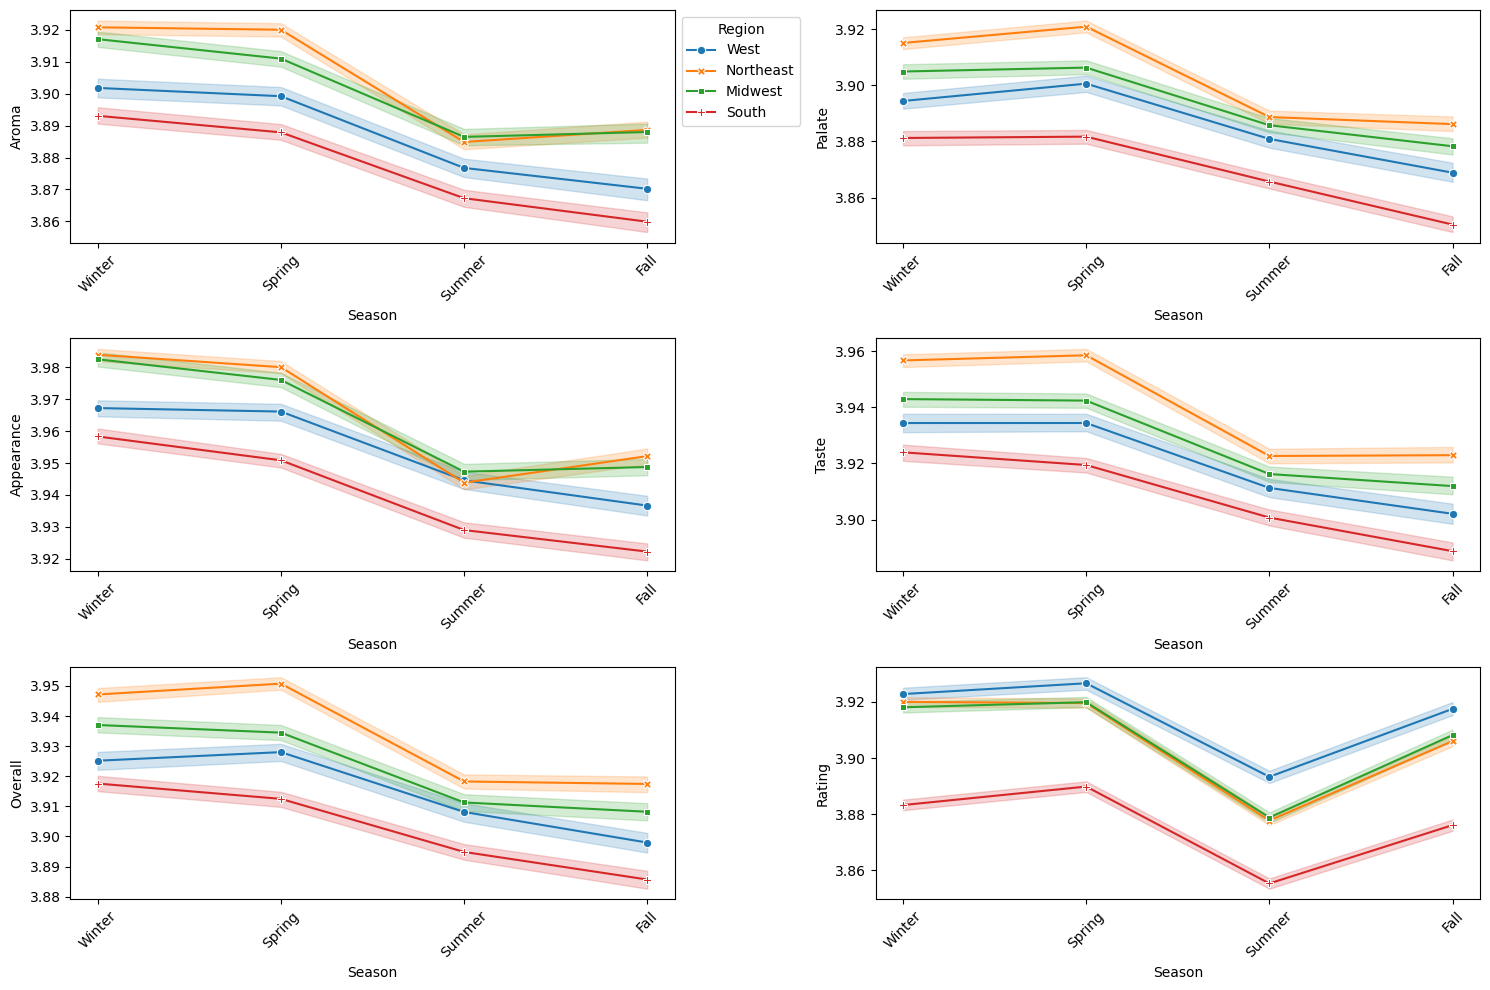

In [60]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']


plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings, x='season', y=rating, hue='region', style='region', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We observe a similar trend across all rating categories (aroma, palate, taste, appearance, overall, and rating). Therefore, we can continue the analysis by focusing on the ‘rating’ variable, which serves as a composite score derived from the other five ratings.

South users give the lowest ratings across all season.

In [61]:
from src.scripts.statistics import seasonal_region_test

In [62]:
anova_results= seasonal_region_test(ratings, rating_column='rating') 

Season: Summer, Rating Column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0011 0.8359 -0.0044  0.0022  False
  Midwest     South  -0.0234    0.0 -0.0269   -0.02   True
  Midwest      West   0.0145    0.0  0.0107  0.0182   True
Northeast     South  -0.0224    0.0 -0.0257 -0.0191   True
Northeast      West   0.0156    0.0  0.0119  0.0192   True
    South      West   0.0379    0.0  0.0342  0.0417   True
----------------------------------------------------------
--------------------------------------------------
Season: Winter, Rating Column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------

In all seasons, the South region consistently shows significant differences when compared to the other regions, with the West and Midwest regions also exhibiting notable differences.

#### Comparaison by states and alcohol content

First, we need to ensure that the number of ratings is relatively consistent across each category:

/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/666525292.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratings_count = ratings.groupby(['abv_category', 'region', 'season'])['overall'].count().reset_index()
/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/666525292.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = ratings_count.pivot_table(


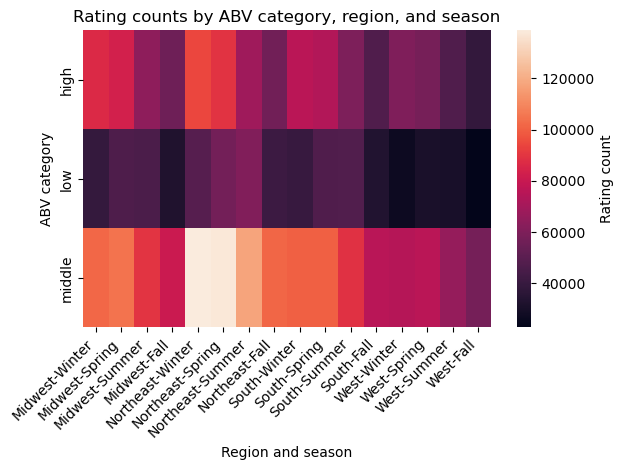

In [63]:
ratings_count = ratings.groupby(['abv_category', 'region', 'season'])['overall'].count().reset_index()
ratings_count = ratings_count.rename(columns={'overall': 'rating_count'})

pivot_table = ratings_count.pivot_table(
    index='abv_category', columns=['region', 'season'], values='rating_count', fill_value=0
)

sns.heatmap(pivot_table, cbar_kws={'label': 'Rating count'})
plt.title("Rating counts by ABV category, region, and season")
plt.xlabel("Region and season")
plt.ylabel("ABV category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The middle abv category has the highest rating count, this is expected as we used 25-50% quantile and the other abv category only 25% of the total number of ratings. There are however more ratings for the Northeast users during winter.  

/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/531321941.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_ratings = ratings.groupby(['season', 'region', 'abv_category'])[rating_columns].mean().reset_index()


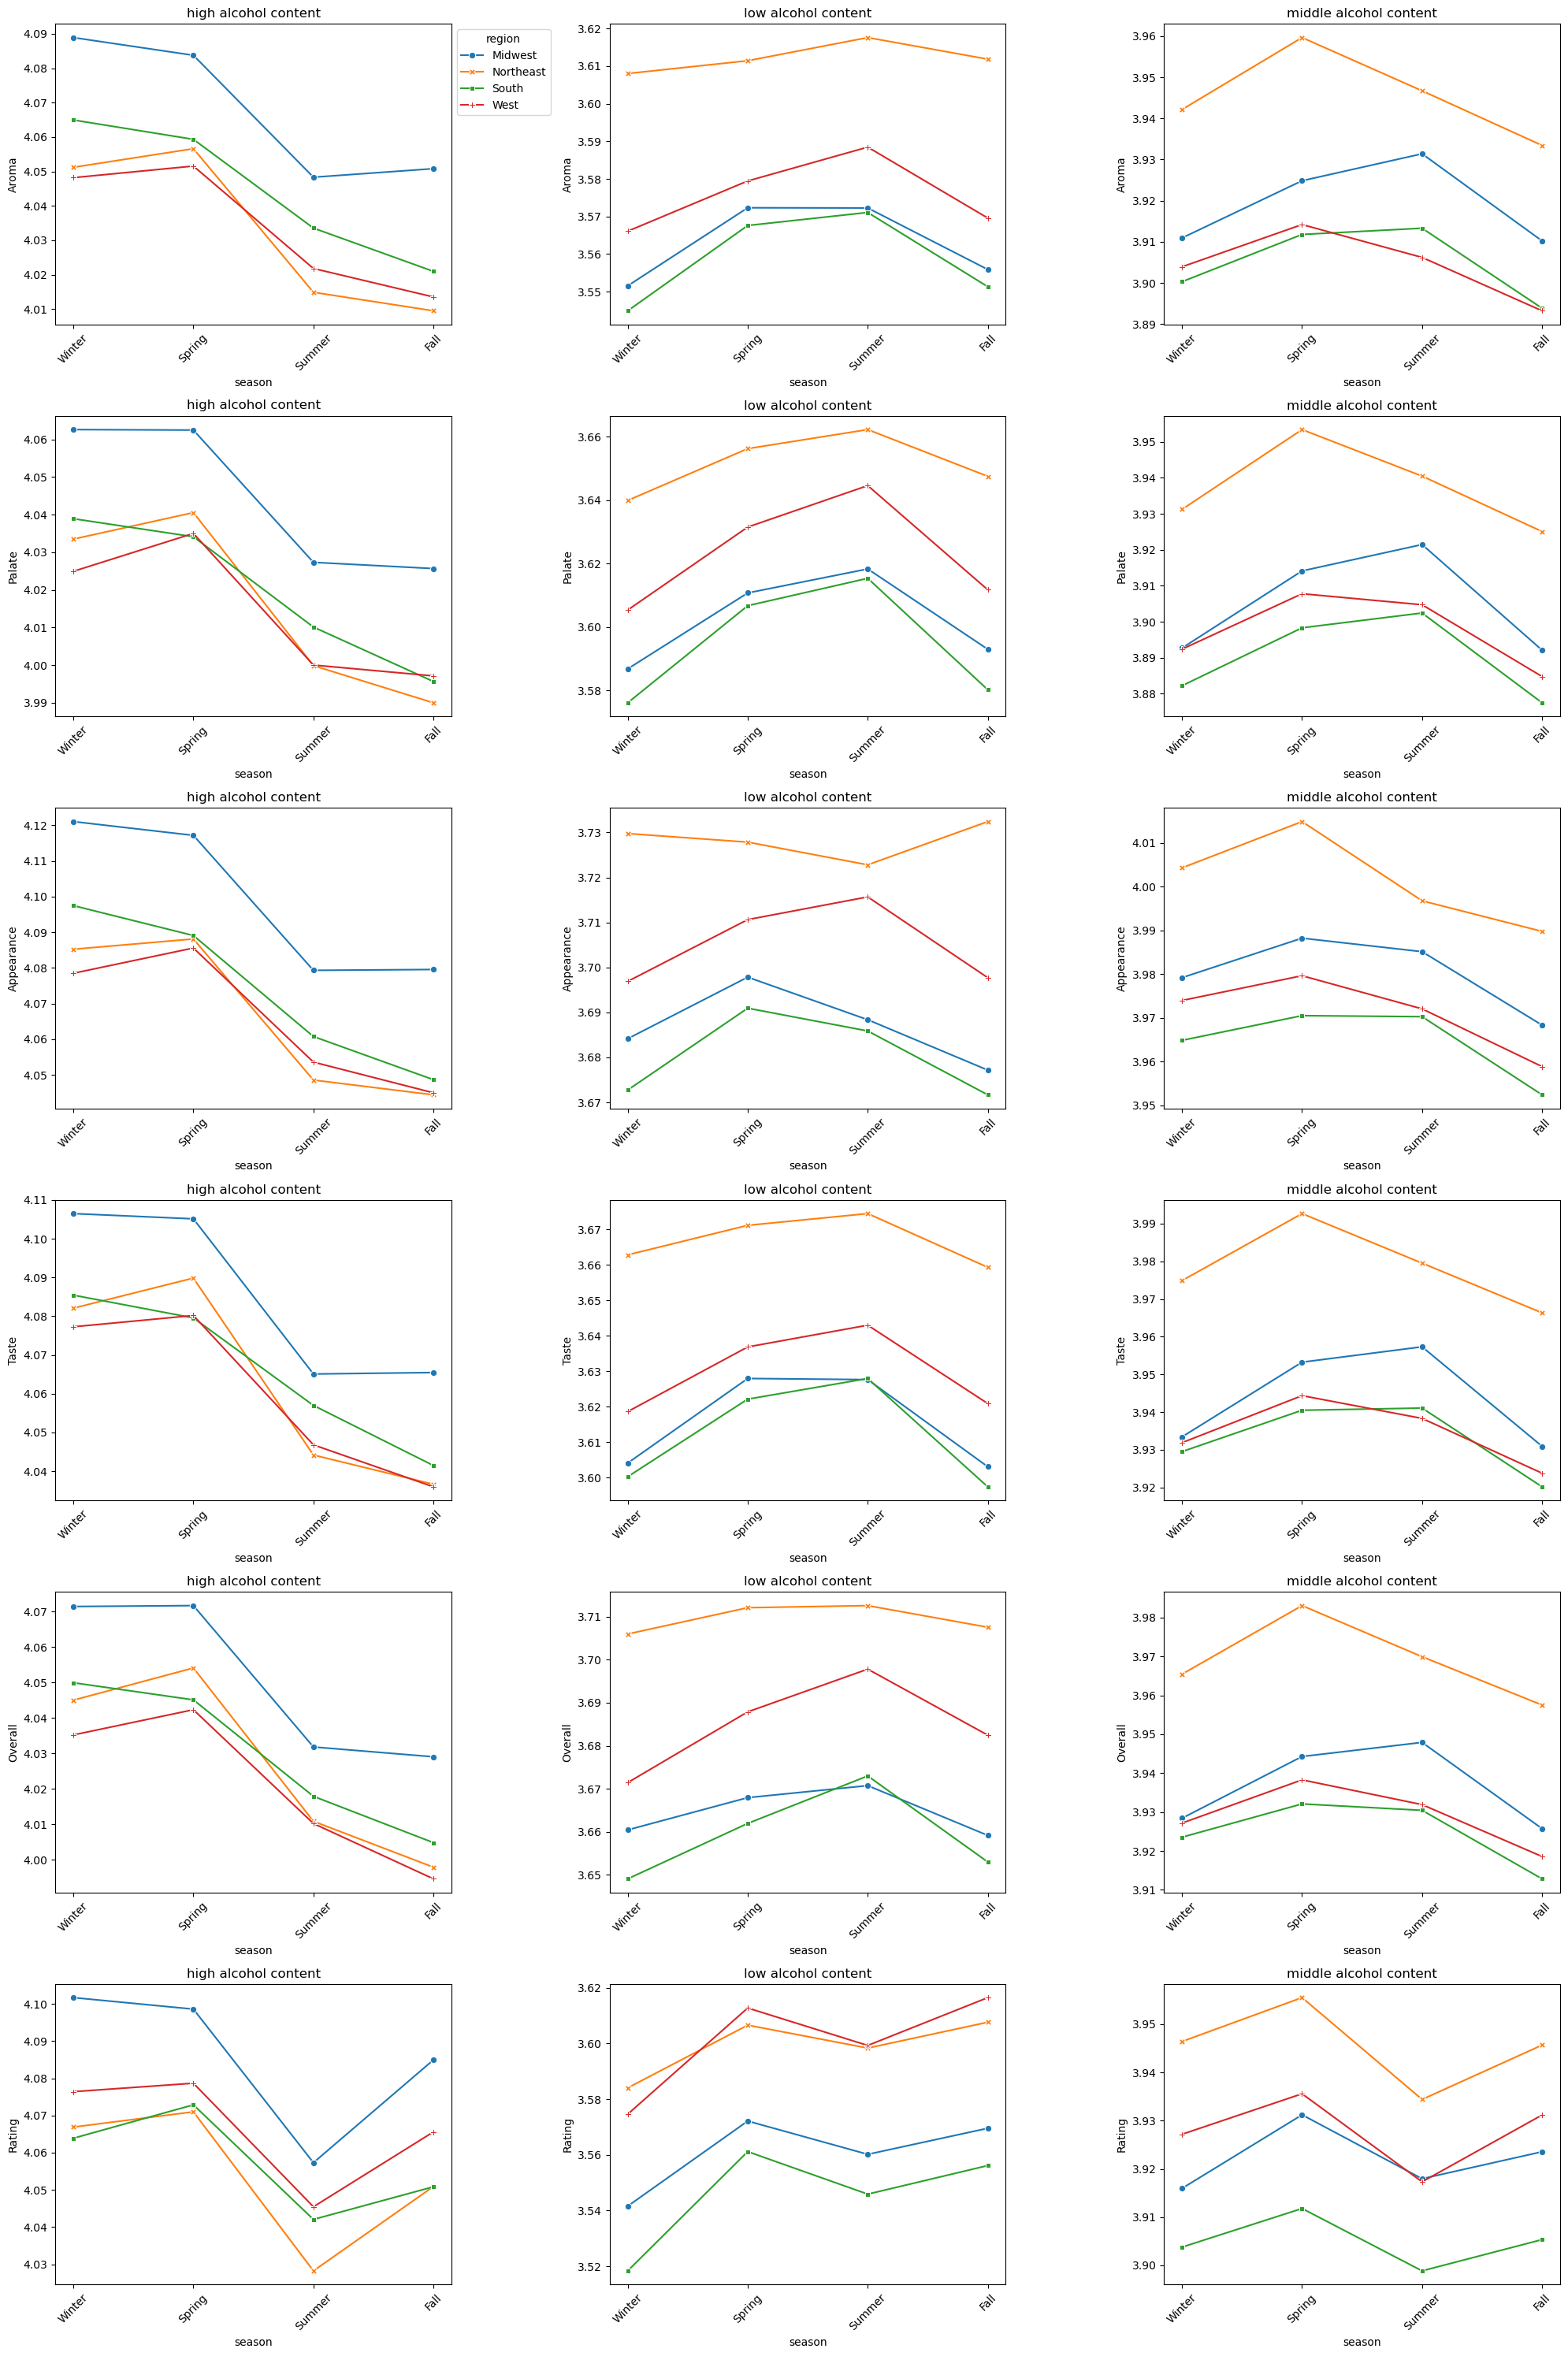

In [64]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']
grouped_ratings = ratings.groupby(['season', 'region', 'abv_category'])[rating_columns].mean().reset_index()

# All ABV categories
abvs = grouped_ratings['abv_category'].unique()

plt.figure(figsize=(20, 30))


for j, rating in enumerate(rating_columns):
    for i, abv in enumerate(abvs):
        
        # Calculate the plot index for the grid
        plt_index = j * len(abvs) + i + 1
        plt.subplot(6, 3, plt_index)
        
        # Filter data for the ABV category
        abv_data = grouped_ratings[grouped_ratings['abv_category'] == abv]
        
        sns.lineplot(data=abv_data, x='season', y=rating, hue='region', style='region', markers=True, dashes=False)
        
        plt.title(f'{abv} alcohol content')
        plt.xlabel('season')
        plt.ylabel(f'{rating.capitalize()}')
        plt.xticks(rotation=45)
        
        if plt_index == 1:
            plt.legend(title='region', loc='upper left', bbox_to_anchor=(1, 1))
        else:
            plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We observe a similar trend across all rating categories (aroma, palate, taste, appearance, overall, and rating). Therefore, we can continue the analysis by focusing on the ‘rating’ variable, which serves as a composite score derived from the other five ratings.

**statistical analysis:**

In [65]:
from src.scripts.statistics import seasonal_region_abv_test

In [66]:
anova_results_low = seasonal_region_abv_test(ratings, abv_category='low', rating_column='rating')

season: Summer, ABV category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0382    0.0  0.0306  0.0457   True
  Midwest     South  -0.0143    0.0 -0.0222 -0.0064   True
  Midwest      West   0.0391    0.0  0.0301  0.0481   True
Northeast     South  -0.0525    0.0 -0.0599  -0.045   True
Northeast      West   0.0009 0.9924 -0.0077  0.0096  False
    South      West   0.0534    0.0  0.0445  0.0623   True
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
-

In [67]:
anova_results_high = seasonal_region_abv_test(ratings, abv_category='high', rating_column='rating')

season: Summer, ABV category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0291    0.0 -0.0346 -0.0236   True
  Midwest     South  -0.0152    0.0 -0.0209 -0.0096   True
  Midwest      West  -0.0118    0.0 -0.0179 -0.0058   True
Northeast     South   0.0138    0.0  0.0082  0.0194   True
Northeast      West   0.0172    0.0  0.0113  0.0232   True
    South      West   0.0034 0.4794 -0.0027  0.0095  False
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject

In [68]:
anova_results_middle = seasonal_region_abv_test(ratings, abv_category='middle', rating_column='rating')

season: Summer, ABV category: middle, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0164    0.0  0.0121  0.0208   True
  Midwest     South  -0.0191    0.0 -0.0237 -0.0145   True
  Midwest      West  -0.0006 0.9876 -0.0056  0.0043  False
Northeast     South  -0.0355    0.0 -0.0399 -0.0312   True
Northeast      West  -0.0171    0.0 -0.0218 -0.0123   True
    South      West   0.0185    0.0  0.0135  0.0234   True
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: middle, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reje

The ratings made by users in different regions (South, Midwest, Northeast, and West) are statistically significant.

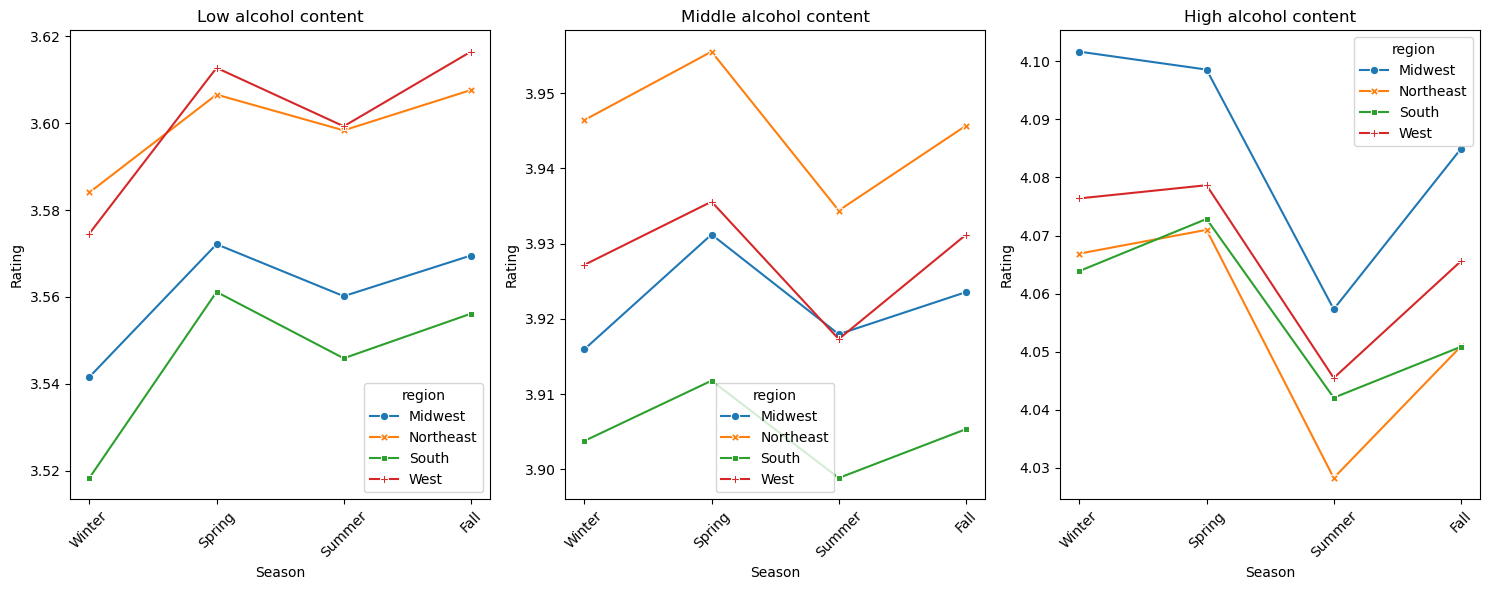

In [69]:
abvs = ['low', 'middle', 'high']  

plt.figure(figsize=(15, 6))  

for j, abv in enumerate(abvs):
    plt_index = j + 1 
    plt.subplot(1, 3, plt_index) 
    
    abv_data = grouped_ratings[grouped_ratings['abv_category'] == abv]
    
    sns.lineplot(data=abv_data, x='season', y='rating', hue='region', style='region', markers=True, dashes=False)
    
    plt.title(f'{abv.capitalize()} alcohol content')
    plt.xlabel('Season')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

 West users give higher ratings for low alcohol content in Spring and Fall than Northeast users but not in Winter. Across all seasons, Northeast users give higher ratings for middle alcohol content, Midwest users for higher alcohol content and Northest and West users for lower alcohol content. 

#### Comparaison by states and alcohol content

In [70]:
best_rated = ratings.groupby(['season', 'region', 'style_simp'])['rating'].mean().reset_index()

# Sort the values by rating in descending order
best_rated = best_rated.sort_values(by=['season', 'region', 'rating'], ascending=[True, True, False])

# Get top 3 beer styles for each region and season
top_3 = best_rated.groupby(['season', 'region']).head(1).reset_index(drop=True)

/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/2822714123.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_rated = ratings.groupby(['season', 'region', 'style_simp'])['rating'].mean().reset_index()
/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_47912/2822714123.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_3 = best_rated.groupby(['season', 'region']).head(1).reset_index(drop=True)


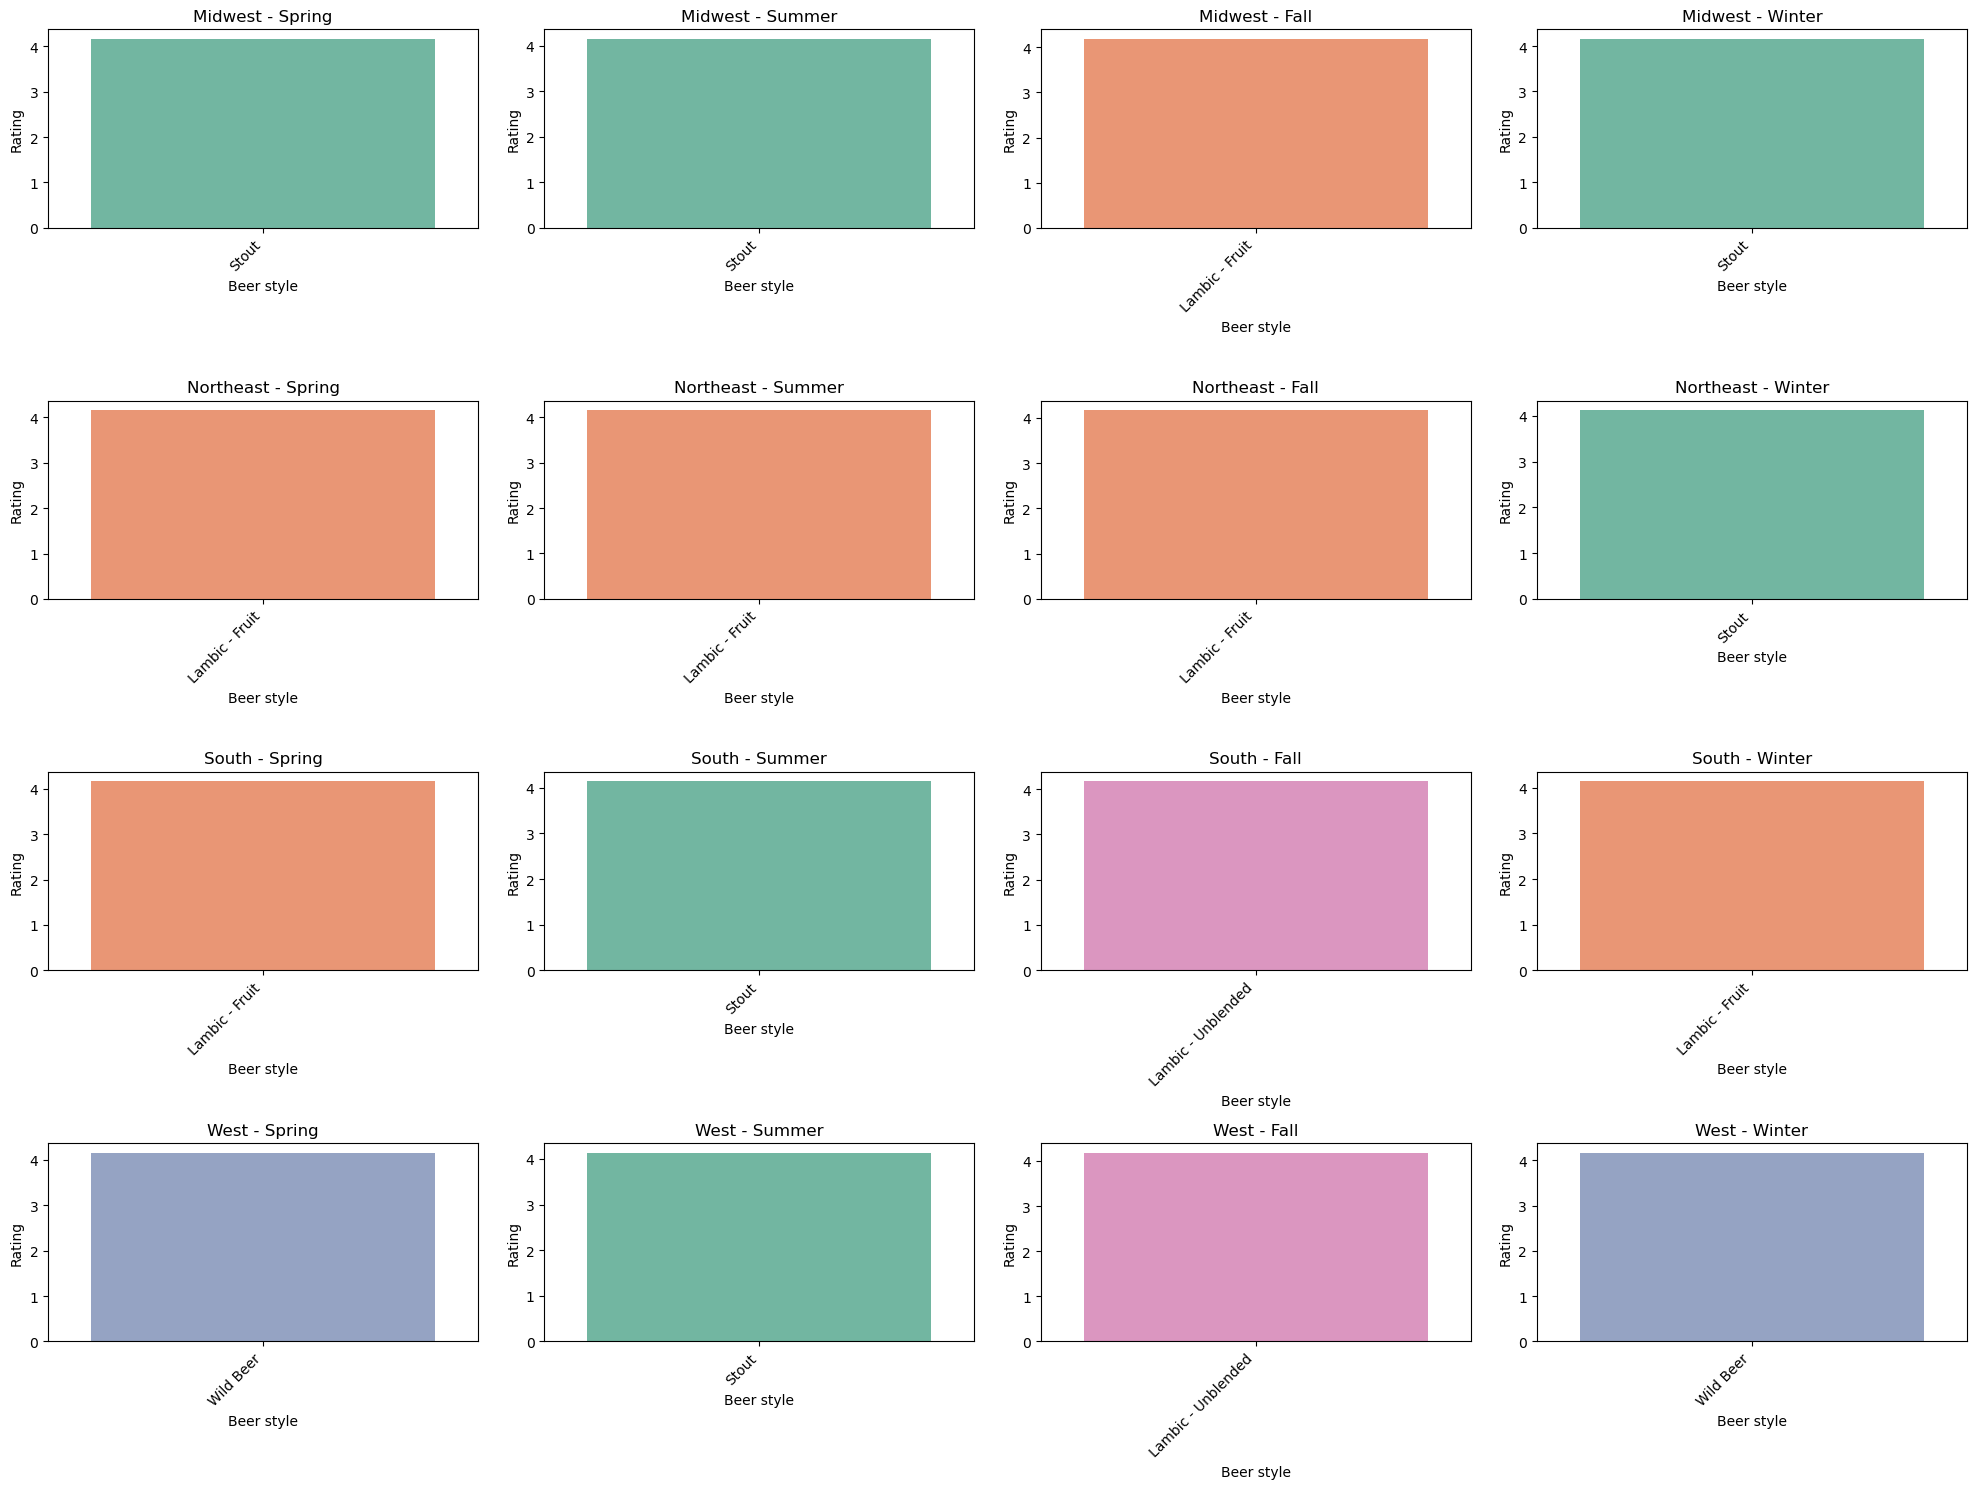

In [71]:
unique_styles = top_3['style_simp'].unique()
style_palette = sns.color_palette("Set2", n_colors=len(unique_styles))  
style_color_map = {style: style_palette[i] for i, style in enumerate(unique_styles)}

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

regions = top_3['region'].unique()
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

for i, region in enumerate(regions):
    for j, season in enumerate(seasons):
        ax = axes[i * 4 + j]
        
        data = top_3[(top_3['region'] == region) & (top_3['season'] == season)]
        
        palette = [style_color_map[style] for style in data['style_simp']]
        
        sns.barplot(x='style_simp', y='rating', data=data, ax=ax, hue='style_simp', palette=palette, legend=False)
        
        ax.set_title(f'{region} - {season}', fontsize=12)
        ax.set_xlabel('Beer style', fontsize=10)
        ax.set_ylabel('Rating', fontsize=10)
        ax.set_xticks(range(len(data['style_simp'])))
        ax.set_xticklabels(data['style_simp'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

The beer style the highest rated is not always the same across season and region. For example, in Summer, for all regions the highest beer style rated is Stout but not for the Northeast region that prefers Lambic Fruit in Summer. The West users tend to change each season the top1 rated beer while the Northeast users always have the Lambic Fruit highest ranked in Summer except in Winter.